### Imports

In [167]:
import os
import sys
import random
import json

In [168]:
import time

In [169]:
import numpy as np

In [170]:
import torch
from torch.utils.data import Dataset

In [171]:
from torch import nn

In [172]:
from torch.nn import functional

In [173]:
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode

In [174]:
from tqdm import tqdm

In [175]:
from datetime import datetime

In [176]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.style.use('dark_background')
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

#### `svetlanna`

In [177]:
from svetlanna.units import ureg

In [178]:
from svetlanna import SimulationParameters
from svetlanna.parameters import ConstrainedParameter

In [179]:
from svetlanna import Wavefront
from svetlanna.transforms import ToWavefront

In [180]:
from svetlanna.elements import FreeSpace, Aperture, RectangularAperture, DiffractiveLayer
from svetlanna.setup import LinearOpticalSetup
from svetlanna.detector import Detector, DetectorProcessorClf

In [181]:
from svetlanna.visualization import show_stepwise_forward

In [182]:
from svetlanna.clerk import Clerk

#### `src`

In [183]:
# dataset of wavefronts
from src.wf_datasets import DatasetOfWavefronts

In [184]:
# training and evaluation loops
from src.clf_loops import onn_train_clf, onn_validate_clf

# Optical Neural Network

### <span style="color:red"> Select the folder with results to load (TODO) </span>

In [185]:
# list of all saved models

DIR_RESULTS = 'results'

filepathes = []

for file in os.listdir(DIR_RESULTS):      
    filename = os.fsdecode(file)
    if os.path.isdir(os.path.join(DIR_RESULTS, filename)):
        filepathes.append(filename)

print(*sorted(filepathes), sep='\n')

exp_20-06-2025_15-09
exp_20-06-2025_22-22
exp_21-06-2025_18-16
exp_21-06-2025_19-57
exp_21-06-2025_20-42
exp_21-06-2025_21-27
exp_22-06-2025_00-04
exp_22-06-2025_09-41
exp_22-06-2025_15-07
exp_22-06-2025_18-12
exp_22-06-2025_18-50
exp_23-06-2025_12-01
exp_23-06-2025_12-42
exp_23-06-2025_12-46
exp_23-06-2025_13-23
exp_23-06-2025_13-46
exp_23-06-2025_14-57


In [186]:
SELECTED_EXP = 'exp_23-06-2025_12-46'  # TODO: select experiment folder from the list above!

In [187]:
RESULTS_FOLDER = f'{DIR_RESULTS}/{SELECTED_EXP}'  

In [188]:
with open(f'{RESULTS_FOLDER}/conditions.json') as json_file:
    LOADED_VARIABLES = json.load(json_file)

In [189]:
LOADED_VARIABLES

{'wavelength': 0.000749481145,
 'neuron_size': 0.00039722500685,
 'mesh_size': [200, 200],
 'use_apertures': False,
 'aperture_size': [200, 200],
 'detector_segment_size': 12.0,
 'segments_order': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'train_val_seed': 40,
 'torch_seed': 4,
 'free_space_distance': 0.029979245800000002,
 'free_space_method': 'AS',
 'train_batch_size': 20,
 'modulation_type': 'amp',
 'val_batch_size': 8,
 'adam_lr': 0.001,
 'number_of_epochs': 10,
 'num_diff_layers': 3}

# 1. Simulation parameters


In [190]:
c_const = 299_792_458  # [m / s]

In [191]:
working_wavelength = LOADED_VARIABLES['wavelength']  # [m]

In [192]:
# neuron size (square)
neuron_size = LOADED_VARIABLES['neuron_size']  # [m]
NEURON_SIZE = neuron_size

In [193]:
print('Specified parameters:')
# uncomment next two lines!
print(f'lambda = {working_wavelength * 1e6:.3f} um')
print(f'neuron size = {neuron_size * 1e6:.3f} um')

Specified parameters:
lambda = 749.481 um
neuron size = 397.225 um


In [194]:
# an actual zone where weights will be updated during a training process
ALL_SIZE = LOADED_VARIABLES['mesh_size']  # for example (100, 100) neurons
USE_APERTURES = LOADED_VARIABLES['use_apertures']

In [195]:
if USE_APERTURES:
    # if we will add apertures we must specify the aperture size here!
    DETECTOR_SIZE = LOADED_VARIABLES['aperture_size']
else:
    DETECTOR_SIZE = ALL_SIZE

In [196]:
# number of neurons in simulation
x_layer_nodes = ALL_SIZE[1]
y_layer_nodes = ALL_SIZE[0]

In [197]:
# calculate physical size of each layer in [m]
x_layer_size_m = x_layer_nodes * neuron_size  # [m]
y_layer_size_m = y_layer_nodes * neuron_size

In [198]:
print(f'Layer size (in neurons): {x_layer_nodes} x {y_layer_nodes} = {x_layer_nodes * y_layer_nodes}')
print(f'Layer size (in cm): {x_layer_size_m * 1e2} x {y_layer_size_m * 1e2}')

Layer size (in neurons): 200 x 200 = 40000
Layer size (in cm): 7.944500137 x 7.944500137


In [199]:
# simulation parameters for the rest of the notebook!

SIM_PARAMS = SimulationParameters(
    axes={
        'W': torch.linspace(-x_layer_size_m / 2, x_layer_size_m / 2, x_layer_nodes),
        'H': torch.linspace(-y_layer_size_m / 2, y_layer_size_m / 2, y_layer_nodes),
        'wavelength': working_wavelength,  # monochromatic!
    }
)  # this is a custom object from our library `svetlanna`

# 2. Dataset preparation

## 2.1. [MNIST Dataset](https://www.kaggle.com/datasets/hojjatk/mnist-dataset)

Here we load dataset of images but we need to transform them to Wavefronts in order to use them for DNN training!

In [200]:
# initialize a directory for a dataset
MNIST_DATA_FOLDER = './data'  # folder to store data

In [201]:
# TRAIN (images)
mnist_train_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=True,  # for train dataset
    download=True,
)
# TEST (images)
mnist_test_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=False,  # for test dataset
    download=True,
)

## 2.2. Create Train and Test datasets of wavefronts

In [202]:
# select modulation type
MODULATION_TYPE = 'amp'  # using ONLY amplitude to encode each picture in a Wavefront!

### 2.2.1. Transformations of images to Wavefronts

In [203]:
resize_y = int(DETECTOR_SIZE[0] / 2)
resize_x = int(DETECTOR_SIZE[1] / 2)  # shape for transforms.Resize

# paddings along OY
pad_top = int((y_layer_nodes - resize_y) / 2)
pad_bottom = y_layer_nodes - pad_top - resize_y
# paddings along OX
pad_left = int((x_layer_nodes - resize_x) / 2)
pad_right = x_layer_nodes - pad_left - resize_x  # params for transforms.Pad

In [204]:
# compose all transforms!
image_transform_for_ds = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Resize(
          size=(resize_y, resize_x),
          interpolation=InterpolationMode.NEAREST,
      ),
      transforms.Pad(
          padding=(
              pad_left,  # left padding
              pad_top,  # top padding
              pad_right,  # right padding
              pad_bottom  # bottom padding
          ),
          fill=0,
      ),  # padding to match sizes!
      ToWavefront(modulation_type=MODULATION_TYPE)  # <- select modulation type!!!
  ]  
)

### 2.2.2. Create Dataset objects for train and test datasets

In [205]:
# TRAIN dataset of WAVEFRONTS
mnist_wf_train_ds = DatasetOfWavefronts(
    init_ds=mnist_train_ds,  # dataset of images
    transformations=image_transform_for_ds,  # image transformation
    sim_params=SIM_PARAMS,  # simulation parameters
)
# TEST dataset of WAVEFRONTS
mnist_wf_test_ds = DatasetOfWavefronts(
    init_ds=mnist_test_ds,  # dataset of images
    transformations=image_transform_for_ds,  # image transformation
    sim_params=SIM_PARAMS,  # simulation parameters
)

# 3. Optical network

In [206]:
NUM_OF_DIFF_LAYERS = 2 #LOADED_VARIABLES['num_diff_layers']  # number of diffractive layers
FREE_SPACE_DISTANCE = LOADED_VARIABLES['free_space_distance']  # [m] - distance between difractive layers

In [207]:
print(f'Distance between layers is {FREE_SPACE_DISTANCE * 1e2:.3f} cm')

Distance between layers is 2.998 cm


## 3.1. Architecture

### 3.1.1. Elements


In [208]:
MAX_PHASE = 2 * np.pi

In [209]:
FREESPACE_METHOD = 'AS'  # we use an angular spectrum method

In [210]:
INIT_PHASES = torch.ones(NUM_OF_DIFF_LAYERS) * np.pi

#### Functions that return single elements for further architecture

In [211]:
# TAKE A LOOK! CODE HERE IS READY
def get_const_phase_layer(
    sim_params: SimulationParameters,
    value: float, 
    max_phase=2 * torch.pi
):
    """
    Returns DiffractiveLayer with a constant phase mask.
    """
    x_nodes, y_nodes = sim_params.axes_size(axs=('W', 'H'))

    const_mask = torch.ones(size=(y_nodes, x_nodes)) * value
    
    return DiffractiveLayer(
        simulation_parameters=sim_params,
        mask=ConstrainedParameter(
            const_mask,
            min_value=0,
            max_value=max_phase
        ),  # HERE WE ARE USING CONSTRAINED PARAMETER! Phases are learnable!
    )

### 3.1.2. List of Elements


In [212]:
def get_elements_list(
    num_layers,
    simulation_parameters,
    freespace_method,
    phase_values,
    apertures=False,
    aperture_size=(100, 100)
):
    """
    Composes a list of elements for the setup.
    ...

    Parameters
    ----------
    num_layers : int
        Number of layers in the system.
    simulation_parameters : SimulationParameters()
        A simulation parameters for a task.
    freespace_method : str
        Propagation method for free spaces in a setup.
    phase_values : torch.Tensor()
        Torch tensor of phase values to generate constant masks for diffractive layers.
        
    apertures : bool
        If True, than before each DiffractiveLayer (and detector) we add a square aperture.
        Comment: there are strickt square apertures!
    aperture_size : tuple
        A size of apertures.
        
    Returns
    -------
    elements_list : list(Element)
        List of Elements for an optical setup.
    """
    elements_list = []  # list of elements

    # -------------------------------------------------- TODO AFTER THE LINE!
    # -----------------------------------------------------------------------
    
    elements_list.append(
        FreeSpace(
            simulation_parameters,
            distance=FREE_SPACE_DISTANCE,
            method=freespace_method,
        )
    )  # first FreeSpace layer before first DiffractiveLayer

    # several layers [Aperture + DiffractiveLayer + FreeSpace]
    for ind_layer in range(num_layers):

        # add square Aperture if needed
        if apertures:
            elements_list.append(
                # your code...
            )
            
        # add DiffractiveLayer (learnable phase mask) and FreeSpace
        elements_list.append(
            get_const_phase_layer(
                simulation_parameters,
                phase_values[ind_layer],
                max_phase=MAX_PHASE
            )
        )
        elements_list.append(
            FreeSpace(
                simulation_parameters,
                distance=FREE_SPACE_DISTANCE,
                method=freespace_method,
            )
        )

    # ----------------------------------------------------------- END OF TODO
    # -----------------------------------------------------------------------

    
    # -----------------------------------------------------------------------
    # add add square Aperture before Detector
    if apertures:
        elements_list.append(
            # your code...  # <-------------------------- HERE IS TODO TOO!!!
        )
    
    # adding a Detector in the end of the system
    # Detector returns torch.tensor of intencities (not a Wavefront - read documentation)
    elements_list.append(
        Detector(
            simulation_parameters=simulation_parameters,
            func='intensity'
        )
    )

    return elements_list

def get_setup(simulation_parameters, apertures=False):
    """
    Returns an optical setup. Recreates all elements.
    """
    elements_list = get_elements_list(
        num_layers=NUM_OF_DIFF_LAYERS,
        simulation_parameters=SIM_PARAMS,
        freespace_method=FREESPACE_METHOD,
        phase_values=INIT_PHASES,
        apertures=apertures,
        aperture_size=DETECTOR_SIZE
    )  # recreate a list of elements

    return LinearOpticalSetup(elements=elements_list)

In [213]:
architecture_elements_list = get_elements_list(
    num_layers=NUM_OF_DIFF_LAYERS,
    simulation_parameters=SIM_PARAMS,
    freespace_method=FREESPACE_METHOD,
    phase_values=INIT_PHASES,
    apertures=USE_APERTURES,
    aperture_size=DETECTOR_SIZE
)

In [214]:
print(f'Number of elements in the system (including Detector): {len(architecture_elements_list)}')

Number of elements in the system (including Detector): 6


### 3.1.3. Compose `LinearOpticalSetup`

In [215]:
def get_setup(simulation_parameters, apertures=False):
    """
    Returns an optical setup. Recreates all elements.
    """
    elements_list = get_elements_list(
        num_layers=NUM_OF_DIFF_LAYERS,
        simulation_parameters=SIM_PARAMS,
        freespace_method=FREESPACE_METHOD,
        phase_values=INIT_PHASES,
        apertures=apertures,
        aperture_size=DETECTOR_SIZE
    )  # recreate a list of elements

    return LinearOpticalSetup(elements=elements_list)

## 3.2. Detector processor

In [216]:
NUMBER_OF_CLASSES = 10  # TODO: how many classes do we have?

### 3.2.1. Detector mask

In [217]:
detector_segment_size = LOADED_VARIABLES['detector_segment_size']  # in neurons (int)
detector_segment_size_m = detector_segment_size * NEURON_SIZE  # in [m]

In [218]:
ZONES_ORDER = LOADED_VARIABLES['segments_order']  # TODO: specify the order

In [219]:
DETECTOR_MASK_LOADED = torch.load(f'{RESULTS_FOLDER}/detector_mask.pt')

### 3.2.2. Detector processor

In [220]:
# create a DetectorProcessorOzcanClf object
DETECTOR_PROCESSOR = DetectorProcessorClf(
    simulation_parameters=SIM_PARAMS,
    num_classes=NUMBER_OF_CLASSES,
    segmented_detector=DETECTOR_MASK_LOADED,
)

#### To visualize detector zones (for further use)

In [221]:
ZONES_HIGHLIGHT_COLOR = 'w'
ZONES_LW = 0.5
selected_detector_mask = DETECTOR_PROCESSOR.segmented_detector.clone().detach()

In [222]:
def get_zones_patches(detector_mask):
    """
    Returns a list of patches to draw zones in final visualisation
    """
    zones_patches = []

    delta = 0.5
    
    for ind_class in range(NUMBER_OF_CLASSES):
        idx_y, idx_x = (detector_mask == ind_class).nonzero(as_tuple=True)
        
        zone_rect = patches.Rectangle(
            (idx_x[0] - delta, idx_y[0] - delta), 
            idx_x[-1] - idx_x[0] + 2 * delta, idx_y[-1] - idx_y[0] + 2 * delta, 
            linewidth=ZONES_LW, 
            edgecolor=ZONES_HIGHLIGHT_COLOR,
            facecolor='none'
        )
        
        zones_patches.append(zone_rect)

    return zones_patches

# 4. Necessary stuff

In [223]:
DEVICE = 'cpu'

In [224]:
train_bs = LOADED_VARIABLES['train_batch_size']  # a batch size for training set
val_bs = LOADED_VARIABLES['val_batch_size']

test_bs = 10

#### Train/Validation split

In [225]:
train_val_split_seed = LOADED_VARIABLES['train_val_seed']

In [226]:
# mnist_wf_train_ds
train_wf_ds, val_wf_ds = torch.utils.data.random_split(
    dataset=mnist_wf_train_ds,
    lengths=[55000, 5000],  # sizes from the article
    generator=torch.Generator().manual_seed(train_val_split_seed)  # for reproducibility
)

#### Loaders

In [227]:
train_wf_loader = torch.utils.data.DataLoader(
    train_wf_ds,
    batch_size=train_bs,
    shuffle=True,
    # num_workers=2,
    drop_last=False,
)

val_wf_loader = torch.utils.data.DataLoader(
    val_wf_ds,
    batch_size=val_bs,
    shuffle=False,
    # num_workers=2,
    drop_last=False,
)

test_wf_loader = torch.utils.data.DataLoader(
    mnist_wf_test_ds,
    batch_size=test_bs,
    shuffle=False,
    # num_workers=2,
    drop_last=False,
)  # data loader for a test MNIST data

#### Loss

In [228]:
loss_func_clf = nn.CrossEntropyLoss()
loss_func_name = 'CE loss'

# 5. Load model weights and estimate perfomance

## 5.1. Loading of saved results

### 5.1.1. Learning curves

In [229]:
losses_data = np.genfromtxt(
    f'{RESULTS_FOLDER}/training_curves.csv',
    delimiter=','
)

In [230]:
NUM_EPOCHS = LOADED_VARIABLES['number_of_epochs']
(train_epochs_losses, val_epochs_losses, train_epochs_acc, val_epochs_acc) = losses_data[1:, :].T

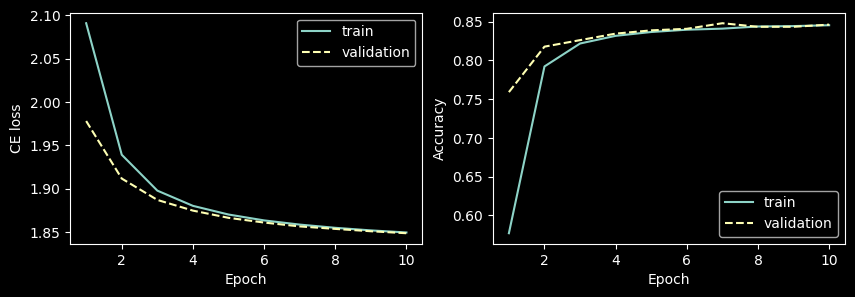

In [231]:
# learning curves plot
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(range(1, NUM_EPOCHS + 1), np.array(train_epochs_losses), label='train')
axs[0].plot(range(1, NUM_EPOCHS + 1), np.array(val_epochs_losses), linestyle='dashed', label='validation')

axs[1].plot(range(1, NUM_EPOCHS + 1), train_epochs_acc, label='train')
axs[1].plot(range(1, NUM_EPOCHS + 1), val_epochs_acc, linestyle='dashed', label='validation')

axs[0].set_ylabel(loss_func_name)
axs[0].set_xlabel('Epoch')
axs[0].legend()

axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()

plt.show()

### 5.1.2. Weights of a model

In [232]:
# init setup to load weights
optical_setup_loaded = get_setup(SIM_PARAMS, LOADED_VARIABLES['use_apertures'])
# LOAD WEIGHTS for the model
optical_setup_loaded.net.load_state_dict(torch.load(f'{RESULTS_FOLDER}/optical_net.pth'))

RuntimeError: Error(s) in loading state_dict for Sequential:
	Unexpected key(s) in state_dict: "5.mask_svtlnn_inner_parameter.inner_parameter", "5.mask_svtlnn_inner_parameter.a", "5.mask_svtlnn_inner_parameter.b". 

### 5.1.3. Trained phase masks visualization

In [ ]:
n_cols = NUM_OF_DIFF_LAYERS  # number of columns for DiffractiveLayer's masks visualization
n_rows = 1

# plot wavefronts phase
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3.2))
ind_diff_layer = 0

cmap = 'gist_stern'  # 'gist_stern' 'rainbow'

for ind_layer, layer in enumerate(optical_setup_loaded.net):
    if isinstance(layer, DiffractiveLayer):  # plot masks for Diffractive layers
        if n_rows > 1:
            ax_this = axs[ind_diff_layer // n_cols][ind_diff_layer % n_cols]
        else:
            ax_this = axs[ind_diff_layer % n_cols]

        ax_this.set_title(f'{ind_diff_layer + 1}. DiffractiveLayer')

        trained_mask = layer.mask.detach()
        
        ax_this.imshow(         
            trained_mask, cmap=cmap,
            vmin=0, vmax=MAX_PHASE
        )
        ind_diff_layer += 1

        # select only a part within apertures!
        # x_frame = (x_layer_nodes - DETECTOR_SIZE[1]) / 2
        # y_frame = (y_layer_nodes - DETECTOR_SIZE[0]) / 2
        # ax_this.set_xlim([x_frame, x_layer_nodes - x_frame])
        # ax_this.set_ylim([y_frame, y_layer_nodes - y_frame])

plt.show()

## 5.2. Calculate metrics on test set for the loaded model

Checking if the loaded model works correctly!

In [ ]:
test_losses_1, _, test_accuracy_1 = onn_validate_clf(
    optical_setup_loaded.net,  # optical network with loaded weights
    test_wf_loader,  # dataloader of training set
    DETECTOR_PROCESSOR,  # detector processor
    loss_func_clf,
    device=DEVICE,
    show_process=True,
)  # evaluate the model

print(
    'Results after training on TEST set:\n' + 
    f'\t{loss_func_name} : {np.mean(test_losses_1):.6f}\n' +
    f'\tAccuracy : {(test_accuracy_1 * 100):>0.1f} %'
)

## 5.3. Example of classification (propagation through the setup)

### 5.3.1. Select a sample to propagate

In [ ]:
# plot an image
# '1' - 3214, good
# '4' - 6152, good
# '6' - 123, good
# '8' - 128, good
# '0' - 3, good
ind_test = 123
cmap = 'hot'

fig, axs = plt.subplots(1, 2, figsize=(2 * 3, 3))

test_wavefront, test_target = mnist_wf_test_ds[ind_test]

axs[0].set_title(f'intensity (id={ind_test})')
axs[0].imshow(test_wavefront.intensity, cmap=cmap)

axs[1].set_title(f'phase')
axs[1].imshow(
    test_wavefront.phase, cmap=cmap,
    vmin=0, vmax=2 * torch.pi
)

plt.show()

In [ ]:
# propagation of the example through the trained network
setup_scheme, test_wavefronts = optical_setup_loaded.stepwise_forward(test_wavefront)

### 5.3.2. Detector picture (enlarged)

In [ ]:
# create a figure with subplots
fig, ax_this = plt.subplots(1, 1, figsize=(3, 3.2))

# Detector output (not a wavefront!)
ax_this.set_title('Detector Intensity')
ax_this.imshow(
    test_wavefronts[-1].detach().numpy(), cmap='hot',
    # vmin=0, vmax=1  # uncomment to make the same limits
)

for zone in get_zones_patches(DETECTOR_MASK_LOADED):
    # add zone's patches to the axis
    ax_this.add_patch(zone)

# select only a part within apertures! uncomment if needed
# x_frame = (x_layer_nodes - DETECTOR_SIZE[1]) / 2
# y_frame = (y_layer_nodes - DETECTOR_SIZE[0]) / 2

# plt.axis([x_frame, x_layer_nodes - x_frame, y_layer_nodes - y_frame, y_frame])

plt.show()

In [ ]:
# get probabilities of an example classification
test_probas = DETECTOR_PROCESSOR.forward(test_wavefronts[-1])
# Comment: forward() method is from DetectorProcessorClf
#          p_i = I(detector_i) / sum_j(I(detector_j))
# Comment: It's another output than for batch_forward, that was used during training!

assert np.isclose(test_probas.sum().item(), 1)

for label, prob in enumerate(test_probas[0]):
    print(f'{label} : {prob * 100:.2f}%')

In [ ]:
def const_diff_layers(num_layers):
    for file in os.listdir(DIR_RESULTS):
        filename = os.fsdecode(file)
        if os.path.isdir(os.path.join(DIR_RESULTS, filename)): ## OS DECODE?    
            results_folder = f'{DIR_RESULTS}/{filename}'
            conditions_file = f'{results_folder}/conditions.json'
            if os.path.exists(conditions_file):
                with open(conditions_file) as json_file:
                    loaded_var = json.load(json_file)
                if 'num_diff_layers' in loaded_var.keys() and loaded_var['num_diff_layers'] == num_layers:
                    yield filename

In [ ]:
N_LAYERS = 3
def predict_test(optical_setup_loaded, detector_processor):
    targets_test_lst = []
    preds_test_lst = []  # lists of targets and model predictioons
    
    # loop over the test dataset
    for ind, (wavefront_this, target_this) in enumerate(tqdm(mnist_wf_test_ds)):
        optical_setup_loaded.net.eval()
        
        batch_wavefronts = torch.unsqueeze(wavefront_this, 0)
        batch_labels = torch.unsqueeze(torch.tensor(target_this), 0)  # to use forwards for batches
        
        with torch.no_grad():
            detector_output = optical_setup_loaded.net(batch_wavefronts)
            # process a detector image
            batch_probas = DETECTOR_PROCESSOR_LOADED.batch_forward(detector_output)
    
            for ind_in_batch in range(batch_labels.size()[0]):
                label_this = batch_labels[ind_in_batch].item()  # true label
                
                targets_test_lst.append(label_this)
                preds_test_lst.append(batch_probas[ind_in_batch].argmax().item())
    confusion_matrix = torch.zeros(
        size=(200, 200),  # TODO: What is the size of the matrix?
        dtype=torch.int32
    )
    
    for ind in range(len(mnist_wf_test_ds)):
        confusion_matrix[targets_test_lst[ind], preds_test_lst[ind]] += 1
    
    return confusion_matrix
for exp in const_diff_layers(N_LAYERS):
    predict_test()